In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from torchinfo import summary
import seaborn as sns
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) 
that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text.
At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model.
One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks.
Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time.
Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants.
In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'''

In [4]:
import torch
# Creating character vocabulary
chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Preparing the dataset
max_length = 10  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
import torch.nn as nn
import torch.nn.functional as F

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, dropout=0.2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output



In [6]:
# Hyperparameters
hidden_size =16
num_layers = 3
nhead = 8
learning_rate = 0.005
epochs = 100

training_loss = []
val_losses = []
val_acc = []
# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    training_loss.append(loss)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
        val_acc.append(val_accuracy)

    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Predicting the next character
test_str = "This is a simple example to demonstrate how to predict the next char"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)
print(f"Predicted next character: '{predicted_char}'")

training_loss = [loss.item() for loss in training_loss]
val_losses = [loss.item() for loss in val_losses]
val_acc = [acc.item() for acc in val_acc]

Epoch 1, Loss: 4.174921989440918, Validation Loss: 3.6017768383026123, Validation Accuracy: 0.05882353335618973
Epoch 2, Loss: 3.6285510063171387, Validation Loss: 3.527055263519287, Validation Accuracy: 0.1260504275560379
Epoch 3, Loss: 3.5681312084198, Validation Loss: 3.490452527999878, Validation Accuracy: 0.1260504275560379
Epoch 4, Loss: 3.5323166847229004, Validation Loss: 3.4543933868408203, Validation Accuracy: 0.1260504275560379
Epoch 5, Loss: 3.4872031211853027, Validation Loss: 3.4153361320495605, Validation Accuracy: 0.1260504275560379
Epoch 6, Loss: 3.4509947299957275, Validation Loss: 3.3750832080841064, Validation Accuracy: 0.1260504275560379
Epoch 7, Loss: 3.4004709720611572, Validation Loss: 3.336623430252075, Validation Accuracy: 0.1260504275560379
Epoch 8, Loss: 3.361943483352661, Validation Loss: 3.3012173175811768, Validation Accuracy: 0.1260504275560379
Epoch 9, Loss: 3.3297054767608643, Validation Loss: 3.2692301273345947, Validation Accuracy: 0.1260504275560379

In [5]:
import torch
# Creating character vocabulary
chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Preparing the dataset
max_length = 20  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
import torch.nn as nn
import torch.nn.functional as F

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, dropout=0.2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output
    
    # Hyperparameters
hidden_size = 16
num_layers = 3
nhead = 2
learning_rate = 0.005
epochs = 100

training_loss1 = []
val_losses1 = []
val_acc1 = []
# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    training_loss1.append(loss)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses1.append(val_loss)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
        val_acc1.append(val_accuracy)

    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]
    
training_loss1 = [loss.item() for loss in training_loss1]
val_losses1 = [loss.item() for loss in val_losses1]
val_acc1 = [acc.item() for acc in val_acc1]

Epoch 1, Loss: 3.9462270736694336, Validation Loss: 3.657501459121704, Validation Accuracy: 0.06751054525375366
Epoch 2, Loss: 3.6394617557525635, Validation Loss: 3.5751945972442627, Validation Accuracy: 0.05485231801867485
Epoch 3, Loss: 3.5908491611480713, Validation Loss: 3.5307018756866455, Validation Accuracy: 0.07172995805740356
Epoch 4, Loss: 3.5447778701782227, Validation Loss: 3.49285626411438, Validation Accuracy: 0.05485231801867485
Epoch 5, Loss: 3.506012439727783, Validation Loss: 3.456244707107544, Validation Accuracy: 0.05485231801867485
Epoch 6, Loss: 3.4566268920898438, Validation Loss: 3.4152657985687256, Validation Accuracy: 0.1497890204191208
Epoch 7, Loss: 3.4255714416503906, Validation Loss: 3.3741414546966553, Validation Accuracy: 0.10759492963552475
Epoch 8, Loss: 3.388082265853882, Validation Loss: 3.3343145847320557, Validation Accuracy: 0.13080167770385742
Epoch 9, Loss: 3.347829818725586, Validation Loss: 3.2966766357421875, Validation Accuracy: 0.158227846

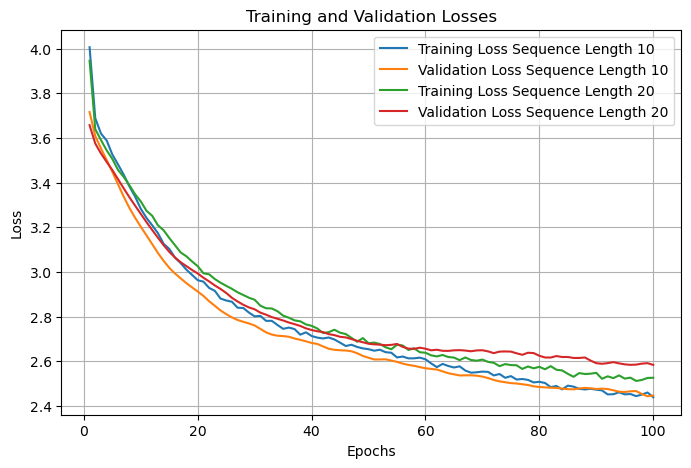

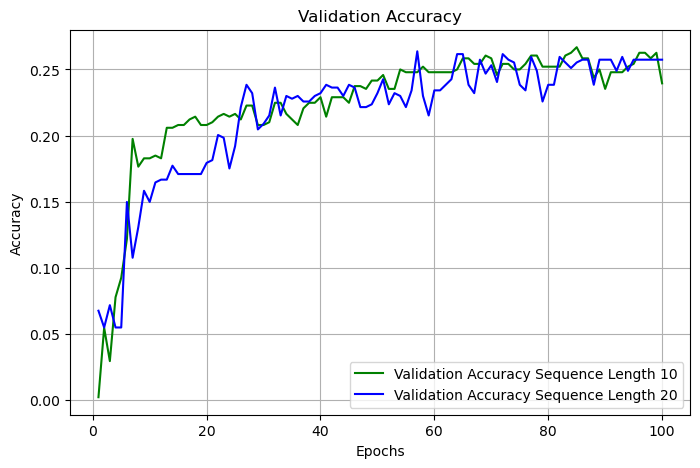

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), training_loss, label='Training Loss Sequence Length 10')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss Sequence Length 10')
plt.plot(range(1, epochs+1), training_loss1, label='Training Loss Sequence Length 20')
plt.plot(range(1, epochs+1), val_losses1, label='Validation Loss Sequence Length 20')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), val_acc, label='Validation Accuracy Sequence Length 10', color='green')
plt.plot(range(1, epochs+1), val_acc1, label='Validation Accuracy Sequence Length 20', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import torch
# Creating character vocabulary
chars = sorted(list(set(text)))
ix_to_char = {i: ch for i, ch in enumerate(chars)}
char_to_ix = {ch: i for i, ch in enumerate(chars)}

# Preparing the dataset
max_length = 30  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
import torch.nn as nn
import torch.nn.functional as F

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, dropout=0.2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output
    
    # Hyperparameters
hidden_size = 16
num_layers = 3
nhead = 2
learning_rate = 0.005
epochs = 100

training_loss2 = []
val_losses2 = []
val_acc2 = []
# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    training_loss2.append(loss)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses2.append(val_loss)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()
        val_acc2.append(val_accuracy)

    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]
    
training_loss2 = [loss.item() for loss in training_loss2]
val_losses2 = [loss.item() for loss in val_losses2]
val_acc2 = [acc.item() for acc in val_acc2]

Epoch 1, Loss: 3.8465723991394043, Validation Loss: 3.499826192855835, Validation Accuracy: 0.08474576473236084
Epoch 2, Loss: 3.4779884815216064, Validation Loss: 3.433770179748535, Validation Accuracy: 0.08474576473236084
Epoch 3, Loss: 3.4058778285980225, Validation Loss: 3.3912546634674072, Validation Accuracy: 0.12923729419708252
Epoch 4, Loss: 3.3676633834838867, Validation Loss: 3.356720447540283, Validation Accuracy: 0.12288135290145874
Epoch 5, Loss: 3.3285939693450928, Validation Loss: 3.3255414962768555, Validation Accuracy: 0.12288135290145874
Epoch 6, Loss: 3.2882189750671387, Validation Loss: 3.2951879501342773, Validation Accuracy: 0.12288135290145874
Epoch 7, Loss: 3.2554378509521484, Validation Loss: 3.2654926776885986, Validation Accuracy: 0.12288135290145874
Epoch 8, Loss: 3.2303247451782227, Validation Loss: 3.2376151084899902, Validation Accuracy: 0.12288135290145874
Epoch 9, Loss: 3.200528144836426, Validation Loss: 3.2124922275543213, Validation Accuracy: 0.12288

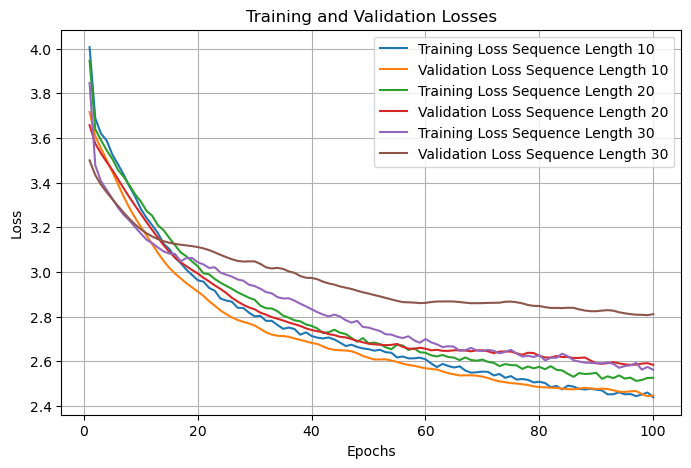

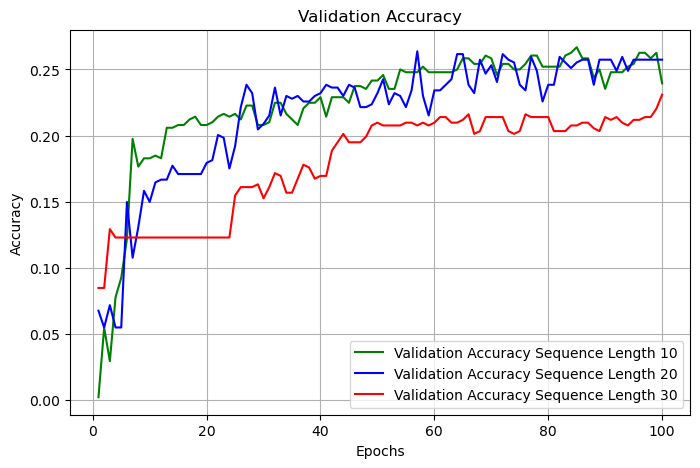

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), training_loss, label='Training Loss Sequence Length 10')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss Sequence Length 10')
plt.plot(range(1, epochs+1), training_loss1, label='Training Loss Sequence Length 20')
plt.plot(range(1, epochs+1), val_losses1, label='Validation Loss Sequence Length 20')
plt.plot(range(1, epochs+1), training_loss2, label='Training Loss Sequence Length 30')
plt.plot(range(1, epochs+1), val_losses2, label='Validation Loss Sequence Length 30')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), val_acc, label='Validation Accuracy Sequence Length 10', color='green')
plt.plot(range(1, epochs+1), val_acc1, label='Validation Accuracy Sequence Length 20', color='blue')
plt.plot(range(1, epochs+1), val_acc2, label='Validation Accuracy Sequence Length 30', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from torchinfo import summary
    # Hyperparameters
hidden_size = 16
num_layers = 3
nhead = 2
learning_rate = 0.005
epochs = 100

training_loss2 = []
val_losses2 = []
val_acc2 = []
# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
summary(model)

Layer (type:depth-idx)                                            Param #
CharTransformer                                                   --
├─Embedding: 1-1                                                  720
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          68,752
│    │    └─TransformerEncoderLayer: 3-2                          68,752
│    │    └─TransformerEncoderLayer: 3-3                          68,752
├─Linear: 1-3                                                     765
Total params: 207,741
Trainable params: 207,741
Non-trainable params: 0

In [ ]:
.